In [5]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install torch-directml
!pip install tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from pathlib import Path
import os
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch_directml
from tqdm import tqdm

In [3]:
# Set variables 

DATA_DIR = Path("Data")
IMAGE_SIZE = (224, 224)

# Change batch size depending on VRAM of gpu, DO NOT EXCEED 350!
BATCH_SIZE = 256 

# Can use up to 8 num workers!! DO NOT EXEED
# 6 cpu bottleneck!?!
NUM_WORKERS = 6

In [4]:
# Get class name from directory structure

CLASS_NAMES = sorted([folder.name for folder in DATA_DIR.iterdir() if folder.is_dir()])
print("Classes:", CLASS_NAMES)

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [5]:
# Im using torchvision instead of OpenCV/cv2 here. 
# Should I use cv2 to grayscale / resize / normalize?

# Define data transformations
# Grayscale and shrink images
# 224 is default for rasnet do not change!!

TRANSFORM = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize(IMAGE_SIZE),

    # Converts image array to float values for tensor
    # 255 (G) -> 1.0
    # HW(RGB) -. CHW (for pytorch)
    transforms.ToTensor(),

    # shiftys and scales data to center around 0 || range has to be -1 to 1
    transforms.Normalize([0.5], [0.5])
])

In [6]:
# Create the dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=TRANSFORM)

In [7]:
total_images = len(dataset)
print(f"Total number of images in the dataset: {total_images}")

Total number of images in the dataset: 21857


In [8]:
# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [9]:
#  Visualize Sample Images
def visualize_sample_images(dataloader, class_names, num_images=9):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i][0], cmap='gray')  
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

Visualizing sample images...


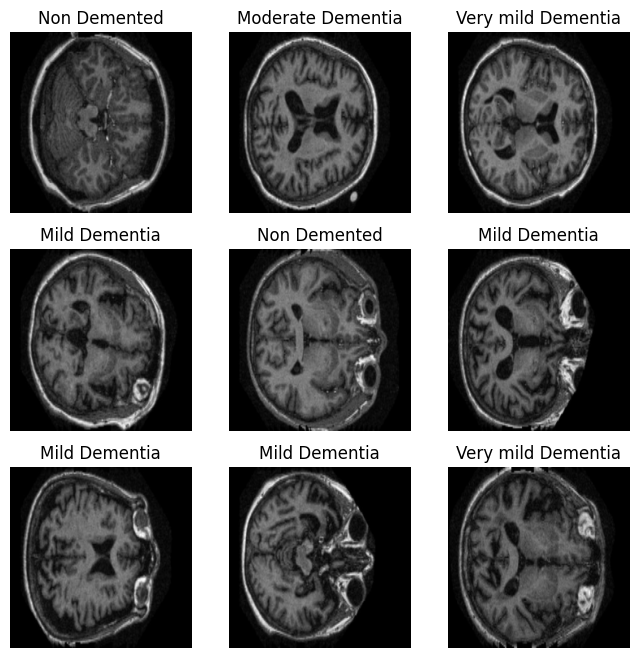

In [10]:
print("Visualizing sample images...")
visualize_sample_images(dataloader, CLASS_NAMES)


In [11]:
# uses directml torch to use AMD GPU (default ones use NVIDA cuda so cannot use!)
# make sure to check activity to see usage on gpu


def get_device(preferred_dml_index=1):
    if torch_directml.is_available():
        device_count = torch_directml.device_count()
        if preferred_dml_index < device_count:
            return torch_directml.device(preferred_dml_index)
        else:
            return torch.device("cpu")
    else:
        return torch.device("cpu")

In [12]:
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: privateuseone:1


In [13]:
# Model  

def create_model(num_classes):
    # Load pretrained ResNet18 model
    model = models.resnet18(pretrained=True)

    # Change the first conv layer to accept 1-channel grayscale images
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Change the last layer to output the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(DEVICE)

model = create_model(len(CLASS_NAMES))

c:\Users\sjhab\OneDrive\Desktop\Project\dementia-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sjhab\OneDrive\Desktop\Project\dementia-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Loss Function and Optimizer

# loss will be highger is prediction is RIGHR and LOWER WHEN ITS CLOSE
CRITERION = nn.CrossEntropyLoss()

# default doc has 0.001... can try increasing for faster performance

# saw on documenation have automatric learning rate to adjust speed overtime??? maybe implement if have time
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Test Forward Pass

# confrims using grayscale -> 1 channel!
# runs a foward pass w/o errors
#  can handle batch size
#  (batch size, channels, height, width)
def test_forward_pass(model, device):
    dummy_input = torch.randn(128, 1, 224, 224).to(device)
    # switch to eval mode
    model.eval()
    with torch.no_grad():
        _ = model(dummy_input)
    print("Forward pass test works!")

In [16]:
# execute above method
test_forward_pass(model, DEVICE)

Forward pass test works!


In [18]:
# Training Loop
NUM_EPOCHS = 5

def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Wrap the dataloader with tqdm for a progress bar
        for inputs, labels in tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

In [19]:
# Execute Model

# batch size = 250 images w/ 4 workers 
# 20 batches for 1 epoch!!!

print("\nStarting training...")
train_model(model, dataloader, CRITERION, OPTIMIZER, NUM_EPOCHS, DEVICE)


Starting training...


Epoch [1/5]:   0%|          | 0/86 [00:00<?, ?it/s]c:\Users\sjhab\OneDrive\Desktop\Project\dementia-env\lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
Epoch [1/5]: 100%|██████████| 86/86 [00:39<00:00,  2.19it/s]


Epoch [1/5] - Loss: 1.1482, Accuracy: 60.59%


Epoch [2/5]: 100%|██████████| 86/86 [00:35<00:00,  2.46it/s]


Epoch [2/5] - Loss: 0.9733, Accuracy: 62.79%


Epoch [3/5]: 100%|██████████| 86/86 [00:35<00:00,  2.43it/s]


Epoch [3/5] - Loss: 0.9726, Accuracy: 62.79%


Epoch [4/5]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [4/5] - Loss: 0.9758, Accuracy: 62.79%


Epoch [5/5]: 100%|██████████| 86/86 [00:34<00:00,  2.46it/s]

Epoch [5/5] - Loss: 0.9736, Accuracy: 62.79%


In [20]:
# Execute Model
print("\nStarting training...")
train_model(model, dataloader, CRITERION, OPTIMIZER, 30, DEVICE)


Starting training...


Epoch [1/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [1/30] - Loss: 0.9734, Accuracy: 62.79%


Epoch [2/30]: 100%|██████████| 86/86 [00:35<00:00,  2.46it/s]


Epoch [2/30] - Loss: 0.9639, Accuracy: 62.79%


Epoch [3/30]: 100%|██████████| 86/86 [00:35<00:00,  2.46it/s]


Epoch [3/30] - Loss: 0.9524, Accuracy: 62.79%


Epoch [4/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [4/30] - Loss: 0.9199, Accuracy: 62.74%


Epoch [5/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [5/30] - Loss: 0.9074, Accuracy: 63.14%


Epoch [6/30]: 100%|██████████| 86/86 [00:35<00:00,  2.42it/s]


Epoch [6/30] - Loss: 0.7844, Accuracy: 68.86%


Epoch [7/30]: 100%|██████████| 86/86 [00:35<00:00,  2.43it/s]


Epoch [7/30] - Loss: 0.5230, Accuracy: 80.76%


Epoch [8/30]: 100%|██████████| 86/86 [00:35<00:00,  2.43it/s]


Epoch [8/30] - Loss: 0.3318, Accuracy: 87.47%


Epoch [9/30]: 100%|██████████| 86/86 [00:35<00:00,  2.43it/s]


Epoch [9/30] - Loss: 0.2041, Accuracy: 92.41%


Epoch [10/30]: 100%|██████████| 86/86 [00:35<00:00,  2.40it/s]


Epoch [10/30] - Loss: 0.1052, Accuracy: 96.28%


Epoch [11/30]: 100%|██████████| 86/86 [00:35<00:00,  2.41it/s]


Epoch [11/30] - Loss: 0.0661, Accuracy: 97.73%


Epoch [12/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [12/30] - Loss: 0.0471, Accuracy: 98.41%


Epoch [13/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [13/30] - Loss: 0.0359, Accuracy: 98.69%


Epoch [14/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [14/30] - Loss: 0.0285, Accuracy: 99.04%


Epoch [15/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [15/30] - Loss: 0.0360, Accuracy: 98.72%


Epoch [16/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [16/30] - Loss: 0.0229, Accuracy: 99.28%


Epoch [17/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [17/30] - Loss: 0.0173, Accuracy: 99.41%


Epoch [18/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [18/30] - Loss: 0.0106, Accuracy: 99.64%


Epoch [19/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [19/30] - Loss: 0.0165, Accuracy: 99.50%


Epoch [20/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [20/30] - Loss: 0.0128, Accuracy: 99.60%


Epoch [21/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [21/30] - Loss: 0.0082, Accuracy: 99.73%


Epoch [22/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [22/30] - Loss: 0.0149, Accuracy: 99.51%


Epoch [23/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [23/30] - Loss: 0.0077, Accuracy: 99.74%


Epoch [24/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [24/30] - Loss: 0.0141, Accuracy: 99.59%


Epoch [25/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [25/30] - Loss: 0.0086, Accuracy: 99.72%


Epoch [26/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [26/30] - Loss: 0.0096, Accuracy: 99.69%


Epoch [27/30]: 100%|██████████| 86/86 [00:35<00:00,  2.45it/s]


Epoch [27/30] - Loss: 0.0129, Accuracy: 99.56%


Epoch [28/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [28/30] - Loss: 0.0105, Accuracy: 99.66%


Epoch [29/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


Epoch [29/30] - Loss: 0.0136, Accuracy: 99.52%


Epoch [30/30]: 100%|██████████| 86/86 [00:35<00:00,  2.44it/s]

Epoch [30/30] - Loss: 0.0081, Accuracy: 99.77%


In [ ]:
## Loss Accuracy by OVERTRAINING MODEL!!

# Sweet Spot is 28 runs

In [ ]:
# Implement model saving!

MODEL_SAVE_PATH = Path("trained_model.pth")

In [21]:
MODEL_SAVE_PATH = Path("trained_model.pth")

In [22]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to: {filepath}")


In [23]:
# Save the trained model
save_model(model, MODEL_SAVE_PATH)

Model saved to: trained_model.pth


In [ ]:
# TKINTER GUI for practical usage